In [493]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import log

import utils.densities as distributions
from main import parse_arguments
import sample as zodmc
import utils.metrics as metrics
import utils.plots as plots

In [494]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d = 2
num_modes = 3
s1, s2, s3 = .1, .1, .1# These are squared
id = torch.eye(d,dtype=torch.double,device=device).unsqueeze(0)
weights = torch.ones((num_modes),dtype=torch.double,device=device)/num_modes
means = torch.tensor([[0.,0.],[5.,5.], [-6.,-8.0]],dtype=torch.double,device=device)
covs = torch.cat([s1 * id, s2 * id, s3 * id],dim=0)
gaussians = [distributions.MultivariateGaussian(means[i],covs[i]) for i in range(num_modes)]
dist = distributions.MixtureDistribution(weights, gaussians)

In [495]:
def rejection_sampler(num_proposals):
    s = max(s1,s2) * 10
    for i in range(num_modes):
        M = max((s/s1)**(d/2), (s/s2)**(d/2) * torch.exp(torch.sum(means[i]**2)/2/(s-s2)).cpu().detach().item())
    prop_dist = distributions.MultivariateGaussian(torch.tensor([0.,0.],dtype=torch.double,device=device), id[0] * s)
    prop = torch.randn((num_proposals,d),device=device).to(dtype=torch.double) * s**.5
    rand = torch.rand((num_proposals,1),device=device).to(dtype=torch.double)
    acc = torch.exp( dist.log_prob(prop) - prop_dist.log_prob(prop) - log(M)) > rand
    acc = acc.expand((-1,2))
    return prop[acc].view(-1,d)

def get_zodmc_config(num_samples):
    config = parse_arguments()[0]
    config.score_method = 'p0t'
    config.p0t_method = 'rejection'
    config.dimension = d
    config.num_batches = 1
    config.sampling_batch_size = num_samples
    config.num_estimator_samples = 5000
    config.sampling_method = 'ei'
    config.T = 2.
    config.sampling_eps = 5e-3
    config.disc_steps = 15
    return config

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:01<00:00, 43.75it/s]


Oracle complexity 50000000 generated 1
666


Oracle complexity 49950000 generated 666


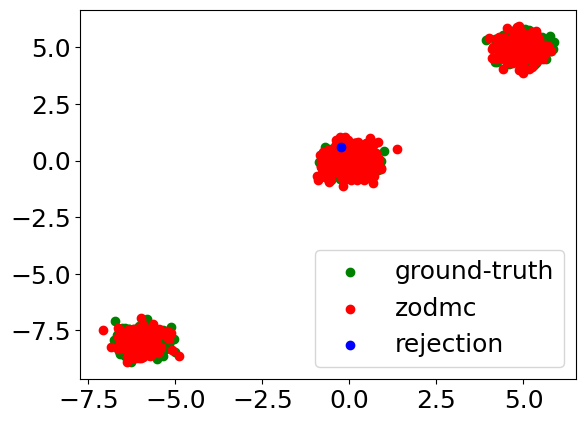

In [496]:
# Rejection
num_proposals = 1000000
num_iters = 50
rej_samples = rejection_sampler(num_proposals)
for i in tqdm(range(num_iters - 1)):
    samples = rejection_sampler(num_proposals)
    rej_samples = torch.cat((rej_samples,samples),dim=0)
oracle_complexity_rej = num_proposals * num_iters
print(f'Oracle complexity {oracle_complexity_rej} generated {rej_samples.shape[0]}')

# ZODMC
num_rej_samples = rej_samples.shape[0]
config = get_zodmc_config(num_rej_samples)
num_zodmc_samples = oracle_complexity_rej//(config.disc_steps * config.num_estimator_samples)
config.sampling_batch_size = num_zodmc_samples
print(config.sampling_batch_size)
zodmc_samples= zodmc.sample(config,distribution=dist)
oracle_complexity_zodmc = config.num_estimator_samples * config.disc_steps * config.sampling_batch_size
print(f'Oracle complexity {oracle_complexity_zodmc} generated {config.sampling_batch_size}')


ground_truth_samples = dist.sample(1000)
# print(f'W2 ZODMC {metrics.get_w2(ground_truth_samples,zodmc_samples)}')
# print(f'W2 REJ {metrics.get_w2(ground_truth_samples,rej_samples)}')

plt.scatter(ground_truth_samples[:,0].cpu().detach().numpy(),
            ground_truth_samples[:,1].cpu().detach().numpy(),color='green')
plt.scatter(zodmc_samples[:,0].cpu().detach().numpy(),
            zodmc_samples[:,1].cpu().detach().numpy(),color='red')
plt.scatter(rej_samples[:,0].cpu().detach().numpy(),
            rej_samples[:,1].cpu().detach().numpy(),color='blue')
plt.legend(['ground-truth','zodmc','rejection'])
plt.show()



In [518]:
def parallel_tempering_langevin_vector(distribution : distributions.Distribution,
                                initial_cond, betass,num_iters,h):
    l = betass.shape[0]
    betas = betass.reshape(l,1,1)
    xchains = initial_cond.expand(l,*initial_cond.shape).clone().to(device)
    for i in tqdm(range(num_iters)):
        xk = xchains
        center = xk + h * betas * distribution.grad_log_prob(xk)
        proposal = center + (2*h)**.5 * torch.randn_like(xk)
        center_proposal = proposal + h * betas * distribution.grad_log_prob(proposal)
        xchains = proposal
        prob1 = distribution.log_prob(proposal) - torch.sum((proposal - center)**2,dim=-1,keepdim=True)/(4*h)
        prob2 = distribution.log_prob(xk)  - torch.sum((xk - center_proposal)**2,dim=-1,keepdim=True)/(4*h)
        acc_rate = torch.exp(prob1 - prob2)
        acc_rate = torch.min(torch.ones_like(acc_rate),acc_rate) 
        acc = torch.rand_like(acc_rate) < acc_rate
        acc = acc.expand((-1,-1,d))
        xchains[acc] = proposal[acc]
        
        for k in range(1,l):
            xii = xchains[k-1]
            xi = xchains[k]
            acc_rate = torch.exp((betas[k] - betas[k-1]) * distribution.log_prob(xii)
                                +(betas[k-1] - betas[k]) * distribution.log_prob(xi))
            acc_rate = torch.min(torch.ones_like(acc_rate),acc_rate)
            acc = torch.rand_like(acc_rate) < acc_rate
            acc = acc.expand((-1,d))
            xchains[k-1][acc] = xi[acc]
            xchains[k][acc] = xii[acc]
    return xchains[l-3]                         

In [523]:
x0 = torch.randn((num_zodmc_samples,2),dtype=torch.double, device=device) 
l = 15
betas = torch.linspace(.2,1.,l, dtype=torch.double,device=device)
num_iters = 100000
parallel_temp_samples = parallel_tempering_langevin_vector(dist,x0,betas,num_iters,.1)
oracle_complexity_parallel = 6 * l * num_iters
plt.scatter(ground_truth_samples[:,0].cpu().detach().numpy(),
            ground_truth_samples[:,1].cpu().detach().numpy(),color='green')
plt.scatter(parallel_temp_samples[:,0].cpu().detach().numpy(),parallel_temp_samples[:,1].cpu().detach().numpy())
plt.show()

 23%|██▎       | 23462/100000 [07:33<24:59, 51.03it/s]

Oracle complexity zodmc       49950000 with W2  2.9351305961608887
Oracle complexity rejection   50000000 with W2  7.212249755859375
Oracle complexity parallel      900000 with W2  26.198102951049805


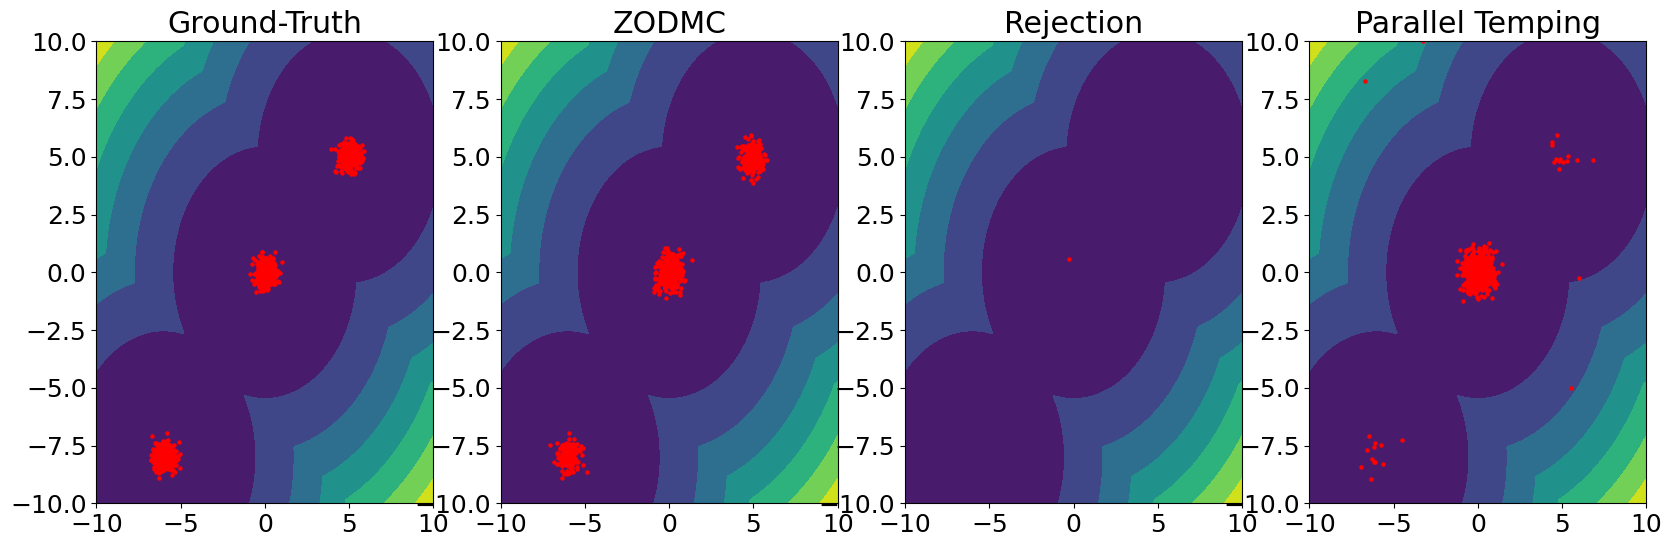

In [522]:
plots.plot_all_samples(
    [ground_truth_samples,zodmc_samples, rej_samples, parallel_temp_samples],
    ['Ground-Truth','ZODMC','Rejection','Parallel Temping'],
    [-10,10], [-10,10],
    dist.log_prob
)
print(f'Oracle complexity zodmc     {oracle_complexity_zodmc : 10} with W2 {metrics.get_w2(ground_truth_samples, zodmc_samples) : 4}')
print(f'Oracle complexity rejection {oracle_complexity_rej : 10} with W2 {metrics.get_w2(ground_truth_samples, rej_samples) : 4}')
print(f'Oracle complexity parallel  {oracle_complexity_parallel : 10} with W2 {metrics.get_w2(ground_truth_samples, parallel_temp_samples) : 4}')
